# Analysis of the Barcelona property market

The script visualizes the property market in Barcelona and identifies the good investment. The data is stored in './data/data.csv' and was obtained using the script 'Idealista API'.

*Author: Mislav Jordanić*

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

df_original = pd.read_csv('./data/data.csv')
df=df_original.copy()

## Organize data

In [2]:
# Remove unnecesarry columns
df = df[['propertyCode', 'floor', 'price', 'propertyType', 'size',
       'exterior', 'rooms', 'bathrooms', 'district', 'neighborhood', 'latitude',
       'longitude', 'priceByArea', 'status', 'hasLift', 'Week']]

df['propertyCode'] = pd.to_numeric(df['propertyCode'], errors='coerce') 
df['propertyType'] = df['propertyType'].astype('category')
df['district'] = df['district'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('category')
df['status'] = df['status'].astype('category')
df['floor'] = df['floor'].astype('str')
# drop identical rows (keep only the first instance)
df.drop_duplicates(inplace=True)

df.reset_index(drop=True, inplace=True)
df.head(5)


propertyCode floor     price propertyType  size  exterior  rooms  \
0      87688139     3  172000.0         flat  67.0     False      2   
1      89127122     2  130000.0         flat  32.0      True      1   
2      89115559     1  149000.0         flat  45.0     False      2   
3      89102591     5  220000.0         flat  54.0      True      2   
4      89123676    bj  103000.0         flat  67.0     False      2   

   bathrooms      district                       neighborhood   latitude  \
0          2      Eixample    L'Antiga Esquerra de l'Eixample  41.387739   
1          1  Ciutat Vella                           El Raval  41.380189   
2          1    Nou Barris                              Porta  41.430582   
3          1      Eixample                 La Sagrada Família  41.410451   
4          1    Nou Barris  Can Peguera - El Turó de la Peira  41.432788   

   longitude  priceByArea status hasLift  Week  
0   2.151873       2567.0    NaN     NaN    14  
1   2.165333       4063.0   good   False    14  
2   2.177449       3311.0   good    True    14  
3   2.178700       4074.0   good    True    14  
4   2.169198       1537.0  renew    True    14

In [3]:
df.dtypes

propertyCode       int64
floor             object
price            float64
propertyType    category
size             float64
exterior            bool
rooms              int64
bathrooms          int64
district        category
neighborhood    category
latitude         float64
longitude        float64
priceByArea      float64
status          category
hasLift           object
Week               int64
dtype: object

In [4]:
# Remove propertise with surface area bigger than 150m2 or price higher than 6000 euros/m2
df=df.loc[df['size'] < 150]
df = df[df['priceByArea'] < 6000]

df.reset_index(drop=True, inplace=True)

In [5]:
# Show basic info of each column and number of NaNs

print('Info')
print(df.info())

print('\n\nNull Elements')
print(df.isnull().sum())

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6383 entries, 0 to 6382
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   propertyCode  6383 non-null   int64   
 1   floor         6383 non-null   object  
 2   price         6383 non-null   float64 
 3   propertyType  6383 non-null   category
 4   size          6383 non-null   float64 
 5   exterior      6383 non-null   bool    
 6   rooms         6383 non-null   int64   
 7   bathrooms     6383 non-null   int64   
 8   district      6261 non-null   category
 9   neighborhood  6244 non-null   category
 10  latitude      6383 non-null   float64 
 11  longitude     6383 non-null   float64 
 12  priceByArea   6383 non-null   float64 
 13  status        5842 non-null   category
 14  hasLift       6157 non-null   object  
 15  Week          6383 non-null   int64   
dtypes: bool(1), category(4), float64(5), int64(4), object(2)
memory usage: 584.0+ KB
None


Nul

## Analyze Duplicates

### Generate index of repeated adds
The index of all properties is generated. Repeated properties have the same index.

E.g. if the following array is given:
(1,2,4,1,5,6,4,1,7,9),

'duplicatesIndex' will have values:
(0,1,2,0,3,4,2,0,5,6)

In [6]:
# to proclaim two rows as duplicates, their values have to be within this tollerances
sizeDifference=1
latitudeDifference=0.0015
longitudeDifference=0.0015
priceByAreaDifference=600

dup=df.copy().reset_index(drop=True)
dup['duplicatesIndex'] = np.nan

# Iterate over each row of data. If duplicates index was not previously set (isnan),
# evaluate which rows are within tollerance and set duplicatesIndex
for index, tup in enumerate(zip(dup['size'], dup['latitude'], dup['longitude'], 
                               dup['priceByArea'], dup['rooms'], dup['bathrooms'], 
                               dup['propertyType'], dup['floor'])):
    if np.isnan(dup.duplicatesIndex.iloc[index]):
        dup.duplicatesIndex.iloc[((np.abs(dup['size'].values-tup[0]) < sizeDifference) &
                            (np.abs(dup['latitude'].values-tup[1]) < latitudeDifference) &
                            (np.abs(dup['longitude'].values-tup[2]) < longitudeDifference) &
                            (np.abs(dup['priceByArea'].values-tup[3]) < priceByAreaDifference) &
                            (dup['rooms'].values == tup[4]) &
                            (dup['bathrooms'].values == tup[5]) & 
                            (dup['propertyType'].values == tup[6]) &
                            (dup['floor'].values == tup[7]))] = index
        
dup['duplicatesIndex'] = dup['duplicatesIndex'].astype(int)

### Remove duplicates
This cell removes the duplicates by grouping them by 'duplicatesIndex' column.
It also generates new columns with minimum and maximum prices extracted from repeated adds and week of first occurence and last occurence of an add.
Moreover, columns with absolute price difference and relative price difference in percentage are extracted.

Dataframe 'df' contains the data with removed duplicates, whereas dataframe 'dup' contains the data with all adds (without removing the duplicates). Dataframe 'df' is used in the further analysis.

In [7]:
dup['duplicates'] = dup.duplicated(subset=['duplicatesIndex'], keep=False)
# Keep the last occurence of a duplicate
df = dup.drop_duplicates(subset=['duplicatesIndex'], keep='last')

# Keep the first occurence of a duplicate 
#df = dup.drop_duplicates(subset=['duplicatesIndex'], keep='first')

group_dup = dup.groupby(['duplicatesIndex'])[[
    'price', 'priceByArea', 'Week']].agg(['count', 'min', 'max'])

group_dup.columns = ['dupPriceCount', 'dupPriceMin', 'dupPriceMax', 
                     'dupPriceByAreaCount','dupPriceByAreaMin', 'dupPriceByAreaMax', 
                     'dupWeekCount', 'dupWeekMin', 'dupWeekMax']
group_dup = group_dup[['dupPriceCount', 'dupPriceMin', 'dupPriceMax', 
                     'dupPriceByAreaMin', 'dupPriceByAreaMax', 
                     'dupWeekMin', 'dupWeekMax']]
group_dup.rename(columns={"dupPriceCount": "duplicatesCount"}, errors="raise", inplace=True)

df = df.join(group_dup, on='duplicatesIndex').reset_index(drop=True)

df['dupPriceDifference'] = (df['dupPriceMax'] - df['dupPriceMin'])
df['dupPriceDifference%'] = 100 * (df['dupPriceDifference'] / df[('dupPriceMax')])

There are 4321 renewed adds without change in price (94.20%)


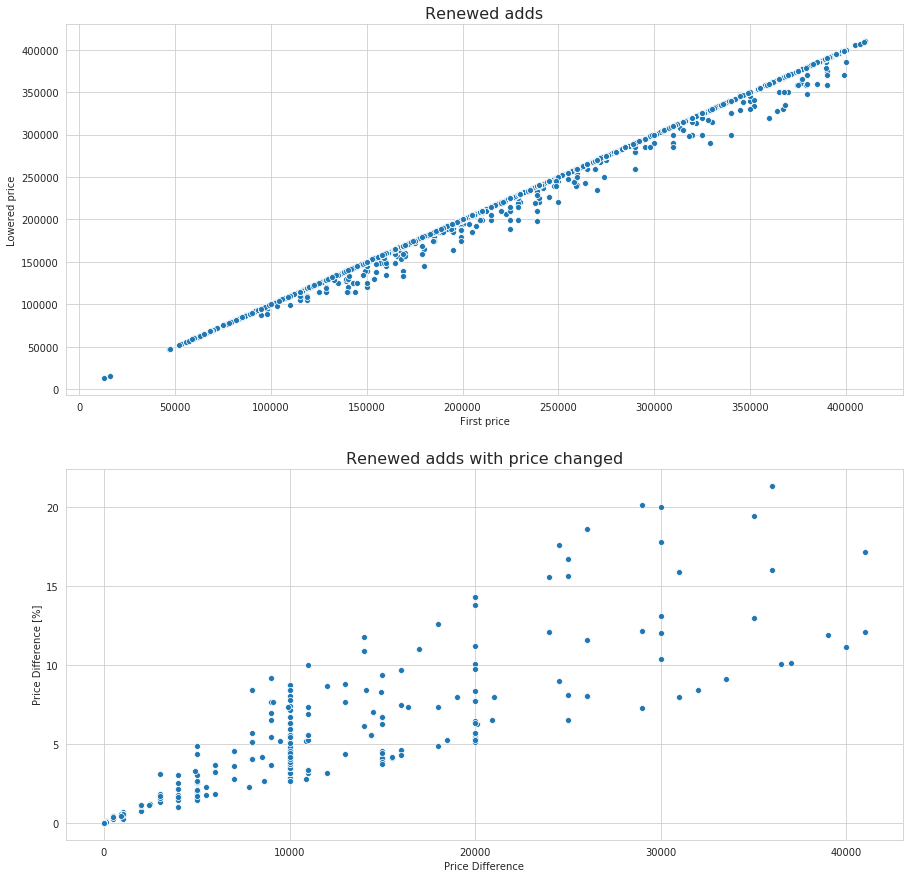

In [8]:
fig_size = (15, 15)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.scatterplot(y='dupPriceMin', x='dupPriceMax', data=df, ax=ax[0])
ax[0].set_title('Renewed adds', fontsize=16)
ax[0].set_xlabel('First price')
ax[0].set_ylabel('Lowered price')

sns.scatterplot(x='dupPriceDifference', y='dupPriceDifference%', data=df, ax=ax[1])
ax[1].set_title('Renewed adds with price changed', fontsize=16)
ax[1].set_xlabel('Price Difference')
ax[1].set_ylabel('Price Difference [%]')

changed_price = ((df['dupPriceMin'] - df['dupPriceMax']) == 0).sum()
percent_changed_price = 100 * changed_price / df.shape[0]
print('There are {} renewed adds without change in price ({:.2f}%)'.format(
    changed_price, percent_changed_price))

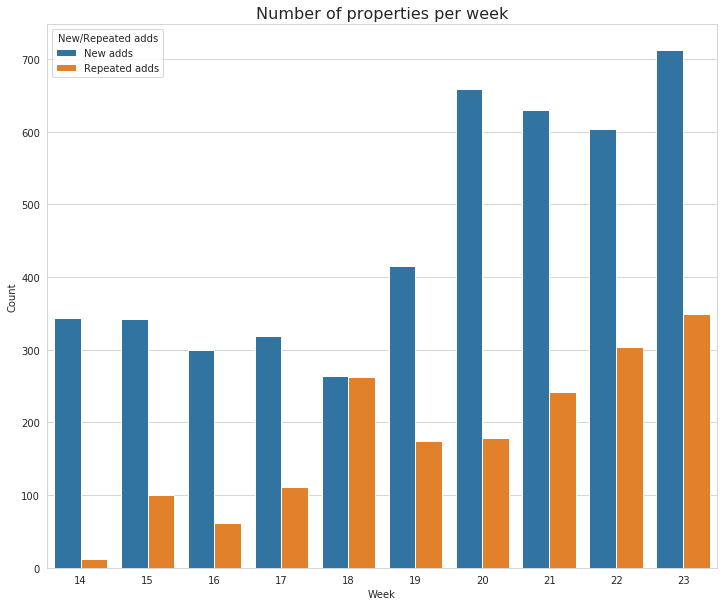

In [9]:
fig_size = (12, 10)
fig, ax = plt.subplots(1, figsize=fig_size)

weeks = pd.concat([dup.Week.value_counts(), dup.drop_duplicates(subset=['duplicatesIndex'], keep='first').Week.value_counts()], axis=1)
weeks.reset_index(inplace=True)
weeks.columns = ['Week', 'All adds', 'New adds']
weeks['Repeated adds'] = weeks['All adds'] - weeks['New adds']
#weeks = pd.melt(weeks, id_vars = 'Week', value_vars=['All adds', 'New adds'], var_name='New/Repeated adds', value_name='Count')
weeks = pd.melt(weeks, id_vars = 'Week', value_vars=['New adds', 'Repeated adds'], var_name='New/Repeated adds', value_name='Count')


sns.barplot(x='Week', y='Count', hue='New/Repeated adds', data=weeks)
ax.set_title(
    'Number of properties per week', fontsize=16);


## Impute missing district and neighborhood
Impute missing district and neighborhood based on kNN and geolocation (latitude, longitude)

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import neighbors

print('\n\n There are '+ repr(df.district.isnull().sum()) +' Null Elements in district to be imputed.')

index_missing = df.index[df.district.isnull()]

X = df.dropna(subset=['district']).loc[:,['latitude', 'longitude']]
y= df.dropna(subset =['district']).loc[:,'district']
assert X.shape[0]==y.shape[0], 'Dimensions do not match!'
model = neighbors.KNeighborsClassifier(2, weights='distance')
## Evaluate a knn model on the dataset using k-fold cross validation
# kfold = KFold(n_splits=3, random_state=7)
# result = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
# print(result.mean())
model.fit(X,y)
df.loc[index_missing, 'district'] = model.predict(X=df.loc[index_missing,['latitude', 'longitude']])



 There are 83 Null Elements in district to be imputed.


In [11]:
print('\n\n There are '+ repr(df.neighborhood.isnull().sum()) +' Null Elements in neighborhood to be imputed.')

index_missing = df.index[df.neighborhood.isnull()]

X = df.dropna(subset=['neighborhood']).loc[:,['latitude', 'longitude']]
y= df.dropna(subset =['neighborhood']).loc[:,'neighborhood']
assert X.shape[0]==y.shape[0], 'Dimensions do not match!'
model = neighbors.KNeighborsClassifier(2, weights='distance')
## evaluate a knn model on the dataset using k-fold cross validation
# kfold = KFold(n_splits=3, random_state=7)
# result = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
# print(result.mean())
model.fit(X,y)
df.loc[index_missing, 'neighborhood'] = model.predict(X=df.loc[index_missing,['latitude', 'longitude']])



 There are 100 Null Elements in neighborhood to be imputed.


## Analyze property types

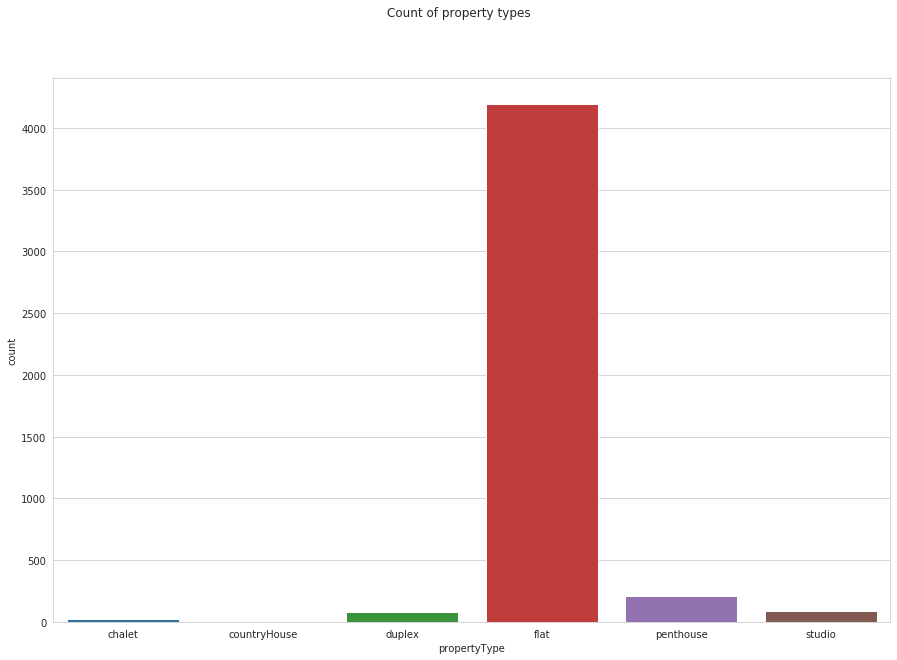

In [12]:
fig_size = (15,10)
fig, ax = plt.subplots(1,figsize=fig_size)
sns.countplot(x='propertyType', data=df, ax=ax);
fig.suptitle('Count of property types');

### Check distribution of Price, Size, and Price by Area

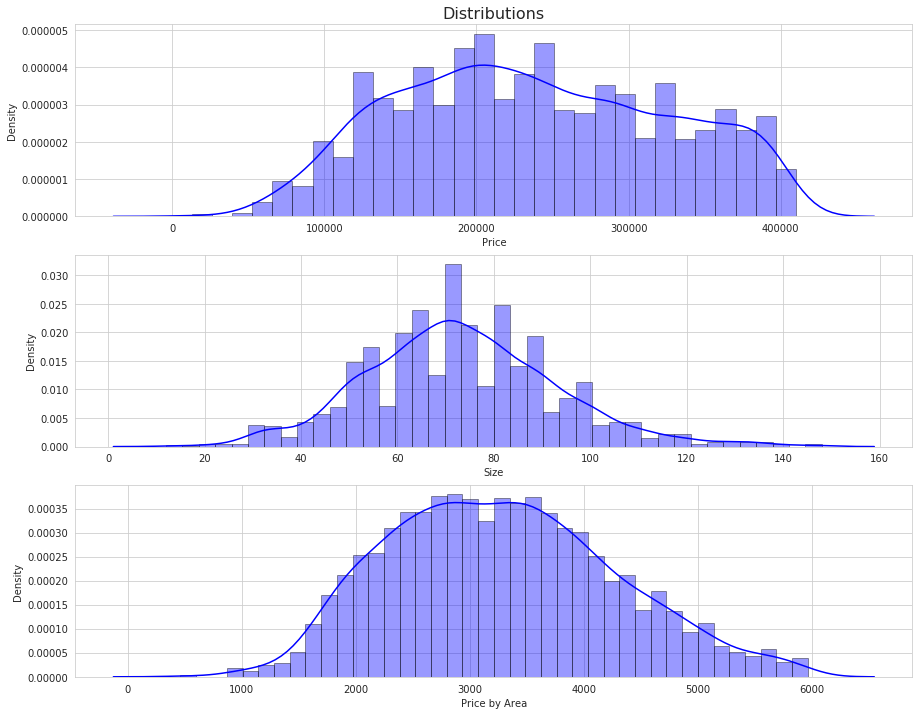

In [13]:
# Prices over 400k are exluded when requesting info from Idealista
fig_size = (15,12)
fig, ax = plt.subplots(3,figsize=fig_size)

sns.distplot(df['price'], hist=True, kde=True, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[0])
ax[0].set_title('Distributions', fontsize=16);
ax[0].set_xlabel('Price');
ax[0].set_ylabel('Density');


sns.distplot(df['size'], hist=True, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[1])
ax[1].set_xlabel('Size');
ax[1].set_ylabel('Density');


sns.distplot(df['priceByArea'], hist=True, kde=True, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[2])
ax[2].set_xlabel('Price by Area');
ax[2].set_ylabel('Density');


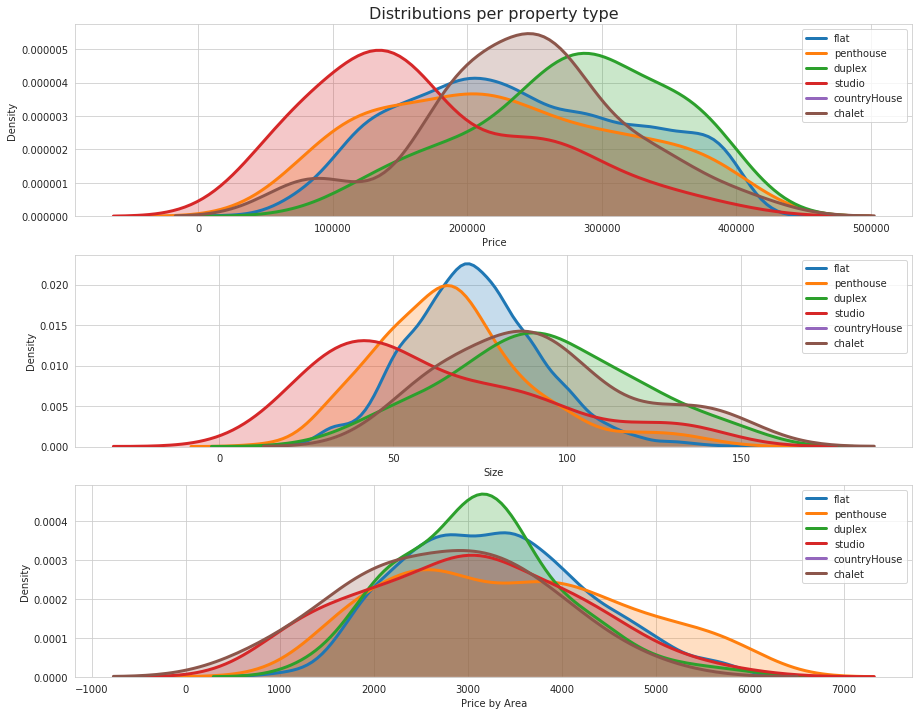

In [14]:
# Check for each type of property

fig_size = (15,12)
fig, ax = plt.subplots(3,figsize=fig_size)

for typeOfProperty in df.propertyType.unique():
    dfDist = df.loc[df['propertyType']==typeOfProperty, ['price', 'size', 'priceByArea']]
    
    sns.distplot(dfDist['price'], hist=False, kde=True, 
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[0])
    
    sns.distplot(dfDist['size'], hist=False, kde=True,
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[1])
    
    sns.distplot(dfDist['priceByArea'], hist=False, kde=True, 
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[2])
    
# Add labels
ax[0].set_title('Distributions per property type', fontsize=16);
ax[0].set_xlabel('Price');
ax[0].set_ylabel('Density');

ax[1].set_xlabel('Size');
ax[1].set_ylabel('Density');

ax[2].set_xlabel('Price by Area');
ax[2].set_ylabel('Density');
    
    

### Scatter plot of Price by Area vs. Size for each property type

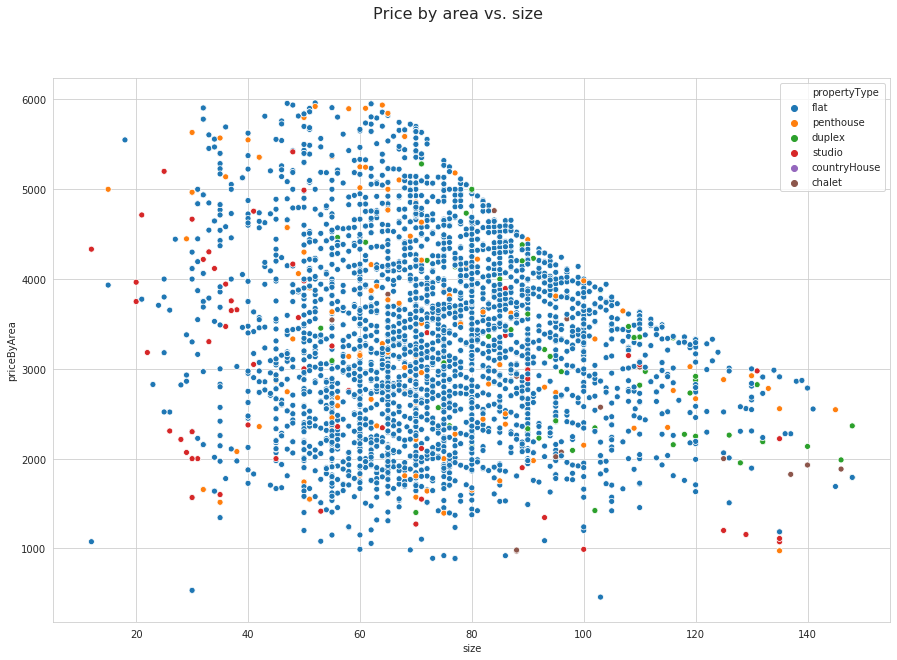

In [15]:
fig_size = (15,10)
fig, ax = plt.subplots(figsize=fig_size)
sns.scatterplot(y='priceByArea', x='size', hue='propertyType', data=df, ax=ax)
fig.suptitle('Price by area vs. size', fontsize=16);


### Number of rooms

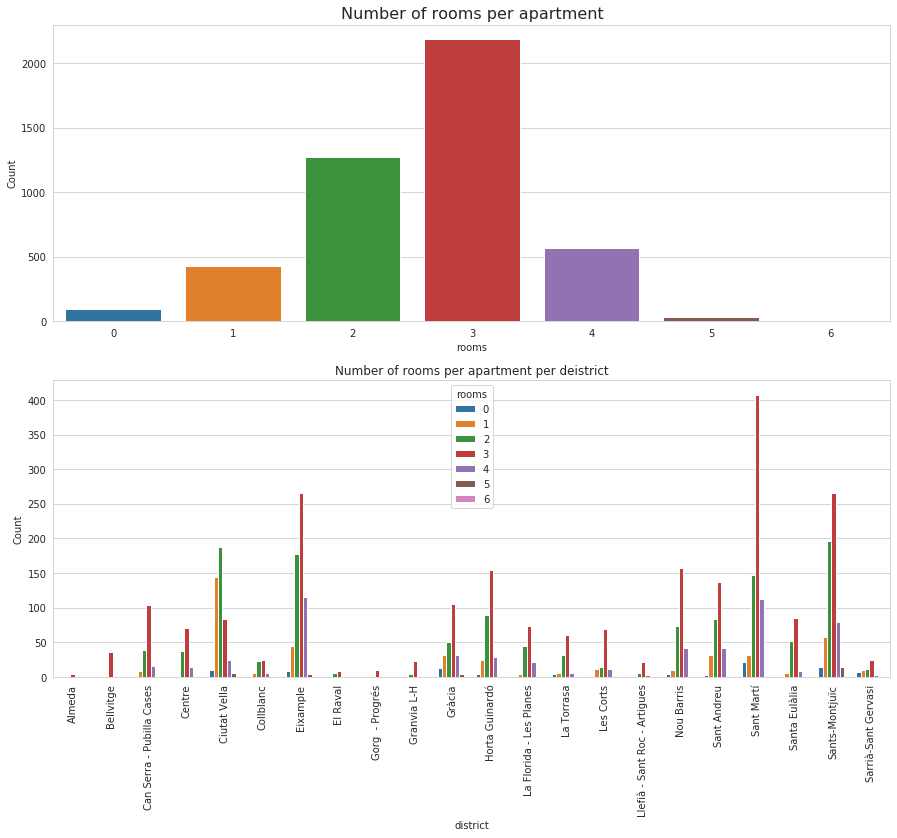

In [16]:
sns.set_style("whitegrid")
fig_size = (15,12)
fig, ax = plt.subplots(2, figsize=fig_size)

sns.countplot(x='rooms', orient = 0, data = df, ax = ax[0])
ax[0].set_title('Number of rooms per apartment', fontsize=16);
ax[0].set_ylabel('Count');

sns.countplot(x = 'district', hue = 'rooms', orient = 0, data = df, ax = ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90);
ax[1].set_title('Number of rooms per apartment per deistrict');
ax[1].set_ylabel('Count');


## Analyze the relationship of floor and price

### Clean floors
Clean floors and create new numerical column 'floorSort' with floor values

In [17]:
df['floor'] = df['floor'].astype('string')
df['floorSort'] = df['floor']
df['floorSort'].replace('en', str(0), inplace= True) # entreplanta = 0
df['floorSort'].replace('bj', str(-1), inplace= True) # bajo = -1
df['floorSort'].replace('ss', str(-1), inplace= True) # semisotano = -1
df['floorSort'].replace('st', str(-1), inplace= True) # semisotano = -1
df['floorSort'].replace('nan', str(-2), inplace= True) # nan = -2
df['floorSort'].replace('Unknown', str(-1), inplace= True) # Set unknown to -2

df.floorSort = df.floorSort.apply(pd.to_numeric)

# 'st' and 'ss' are bothsemisotano
df['floor'].replace('st', 'ss', inplace= True) 

# Show property type 'Penthouse' as floor
df.loc[df['propertyType'] == 'penthouse', 'floor'] =  'Penthouse'# Set unknown to -2
df.loc[df['propertyType'] == 'penthouse', 'floorSort'] =  df.floorSort.max() + 1# Set unknown to -2

# Create new categorical variable with floors
df['floorCategorical'] = df['floor']
df.loc[df['floorSort']==-2, ['floorCategorical']] = None
df.loc[(df['floorSort']>=1)&(df['floorSort']<=3), ['floorCategorical']] = 'Low'
df.loc[(df['floorSort']>=4)&(df['floorSort']<=6), ['floorCategorical']] = 'Mid'
df.loc[(df['floorSort']>=7)&(df['floor']!='Penthouse'), ['floorCategorical']] = 'High'
df['floorCategorical'] = df['floorCategorical'].astype('category')


### Counts and price distribution per floor

Text(0, 0.5, 'Price by Area')

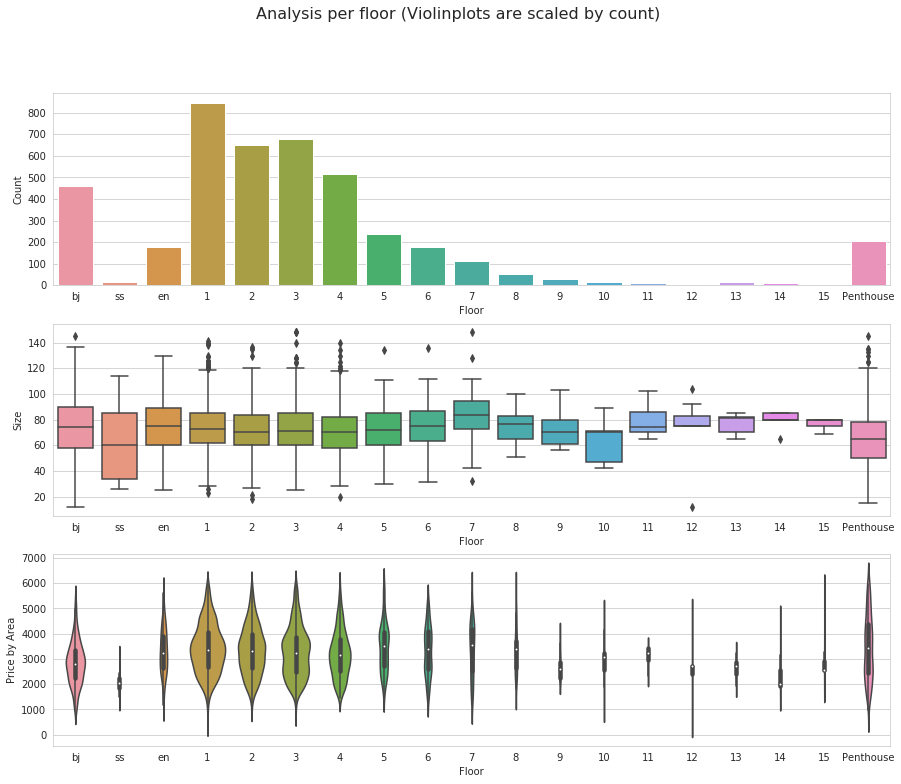

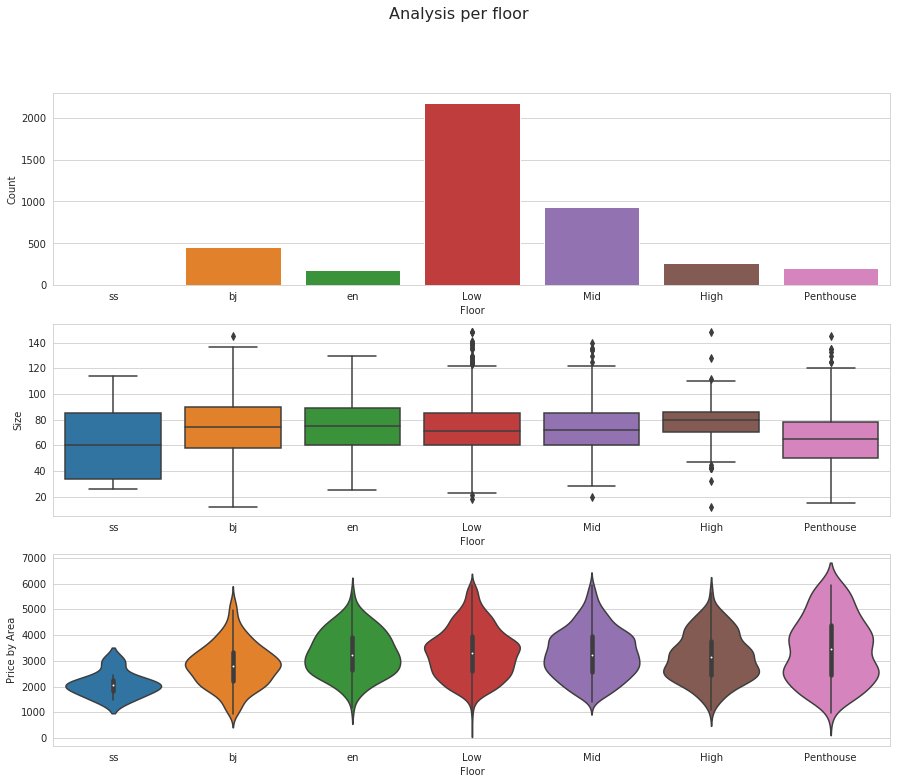

In [18]:
# Do not plot NaNs
fig_size = (15, 12)
fig, ax = plt.subplots(3, figsize=fig_size)
fig.suptitle(
    'Analysis per floor (Violinplots are scaled by count)', fontsize=16)
sns.countplot(x='floor', data=df.loc[df['floorSort'] != -
                                     2].sort_values(by=['floorSort']), orient='v', ax=ax[0])
ax[0].set_xlabel('Floor')
ax[0].set_ylabel('Count')

sns.boxplot(x='floor', y='size',
            data=df.loc[df['floorSort'] != -2].sort_values(by=['floorSort']), ax=ax[1])
ax[1].set_xlabel('Floor')
ax[1].set_ylabel('Size')

sns.violinplot(x='floor', y='priceByArea', scale='count',
               data=df.loc[df['floorSort'] != -2].sort_values(by=['floorSort']), ax=ax[2])
ax[2].set_xlabel('Floor')
ax[2].set_ylabel('Price by Area')


# Plot 'floorCategorical'
fig_size = (15, 12)
fig, ax = plt.subplots(3, figsize=fig_size)
fig.suptitle(
    'Analysis per floor', fontsize=16)
sns.countplot(x='floorCategorical', data=df, order=[
              'ss', 'bj', 'en', 'Low', 'Mid', 'High', 'Penthouse'], orient='v', ax=ax[0])
ax[0].set_xlabel('Floor')
ax[0].set_ylabel('Count')

sns.boxplot(x='floorCategorical', y='size', data=df, order=[
              'ss', 'bj', 'en', 'Low', 'Mid', 'High', 'Penthouse'], ax=ax[1])
ax[1].set_xlabel('Floor')
ax[1].set_ylabel('Size')

sns.violinplot(x='floorCategorical', y='priceByArea', scale='width', data=df,
               order=['ss', 'bj', 'en', 'Low', 'Mid', 'High', 'Penthouse'], ax=ax[2])
ax[2].set_xlabel('Floor')
ax[2].set_ylabel('Price by Area')

### Analyze number of penthouses per district

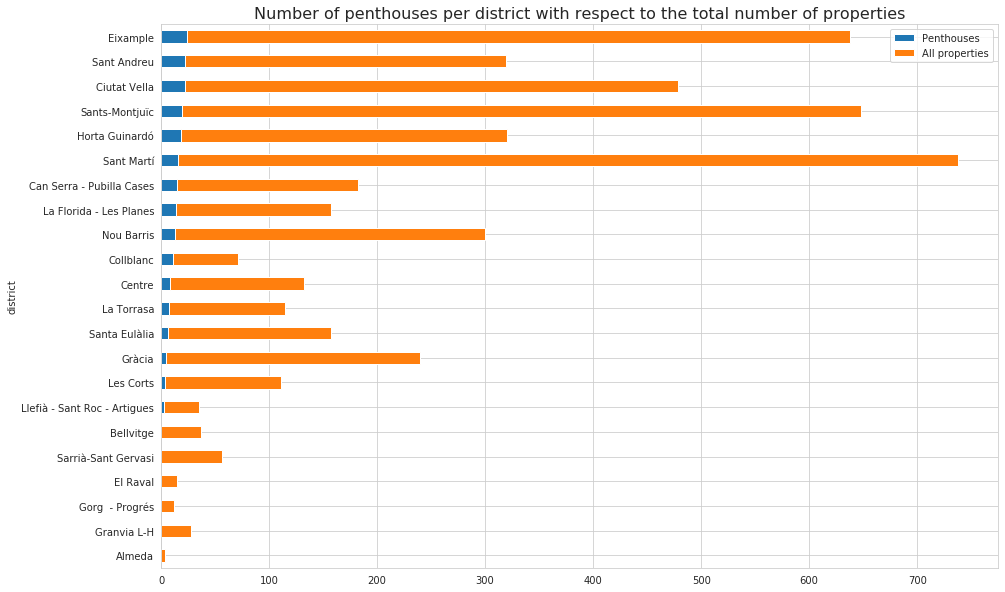

In [19]:
def get_penthouse(x):
    return x.loc[x == 'penthouse'].count()


def get_all_properties(x):
    return x.count()


fig, ax = plt.subplots(1, figsize=(15, 10))


aux = df[['district', 'propertyType']].groupby(['district']).agg(
    [get_penthouse, get_all_properties])
aux.columns = ['Penthouses', 'All properties']
aux.sort_values(by='Penthouses').plot.barh(stacked=True, ax=ax)
ax.set_title(
    'Number of penthouses per district with respect to the total number of properties', 
    fontsize=16);

## Location

### Plot properties to the map
Plot properties and penthouses with respect to price by area and size.

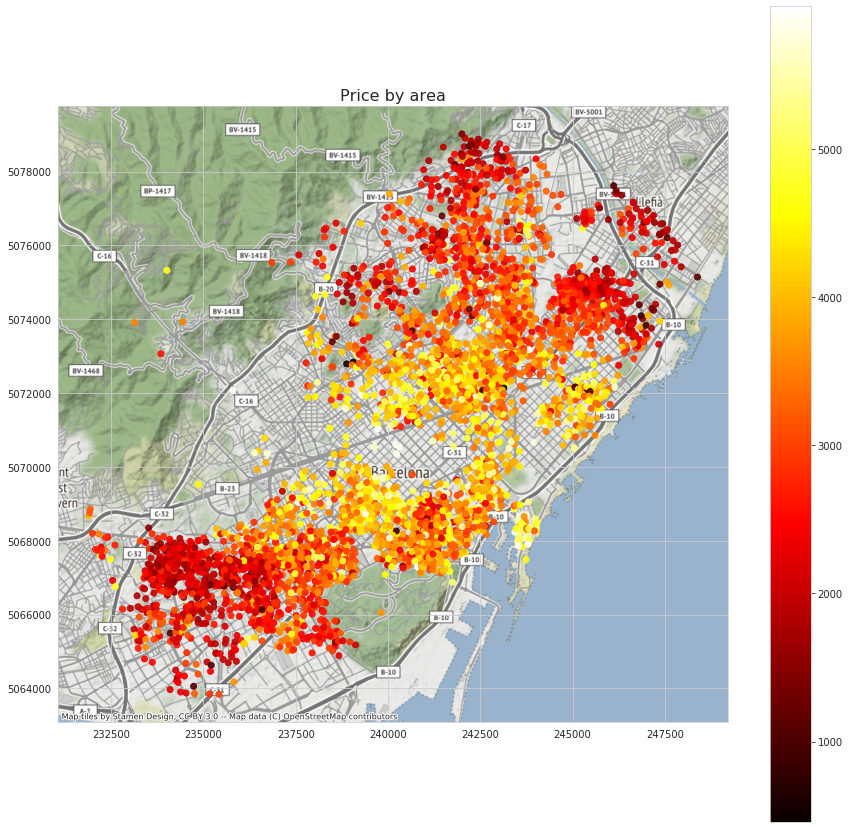

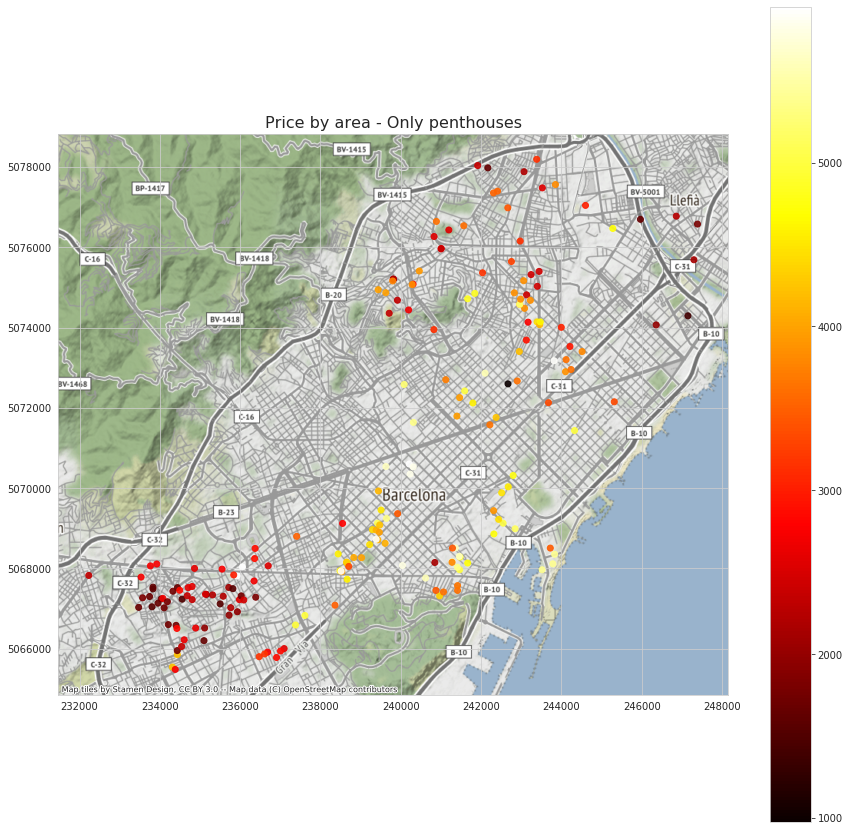

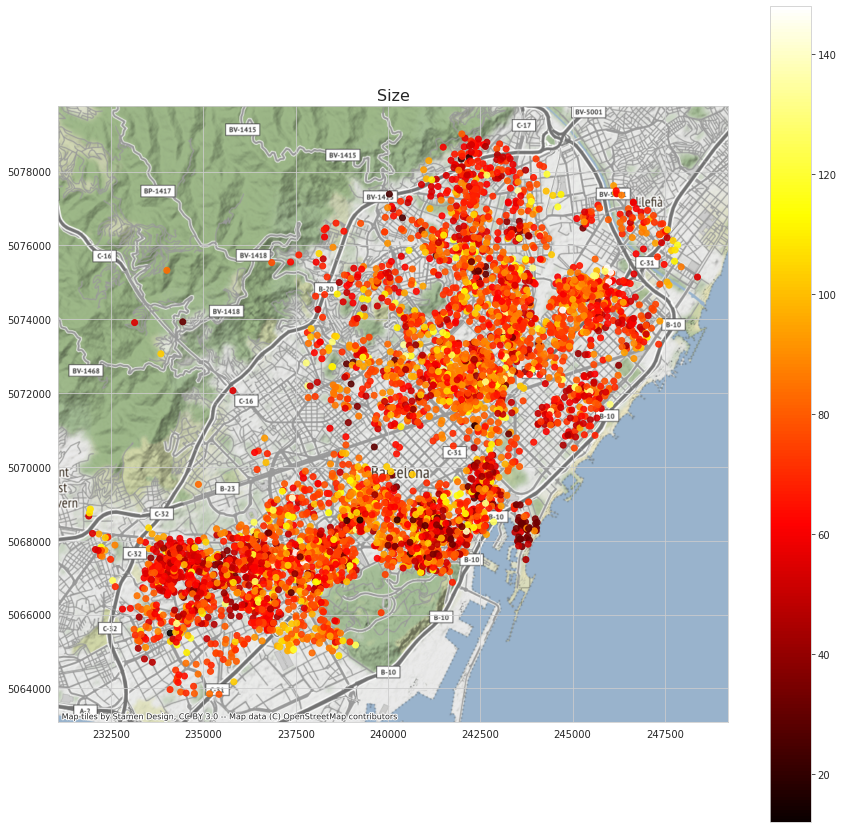

In [20]:
import geopandas as gpd
import descartes
import contextily as ctx


gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

figsize = (15,15)
fig, ax = plt.subplots(1, figsize=figsize)
gdf.plot(column='priceByArea', cmap='hot',  legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Price by area", fontsize=16);

fig, ax = plt.subplots(1, figsize=figsize)
gdf.loc[gdf['propertyType'] == 'penthouse'].plot(
    column='priceByArea', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Price by area - Only penthouses", fontsize=16);

fig, ax = plt.subplots(1, figsize=figsize)
gdf.plot(column='size', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Size", fontsize=16);

### Analyze prices per district
The first figure shows the count and price by area of distrcts sorted by the median district price.
The second figure shows the mean prices and confidence intervals of district plotted per week. The subplots are also plotted by the median district price

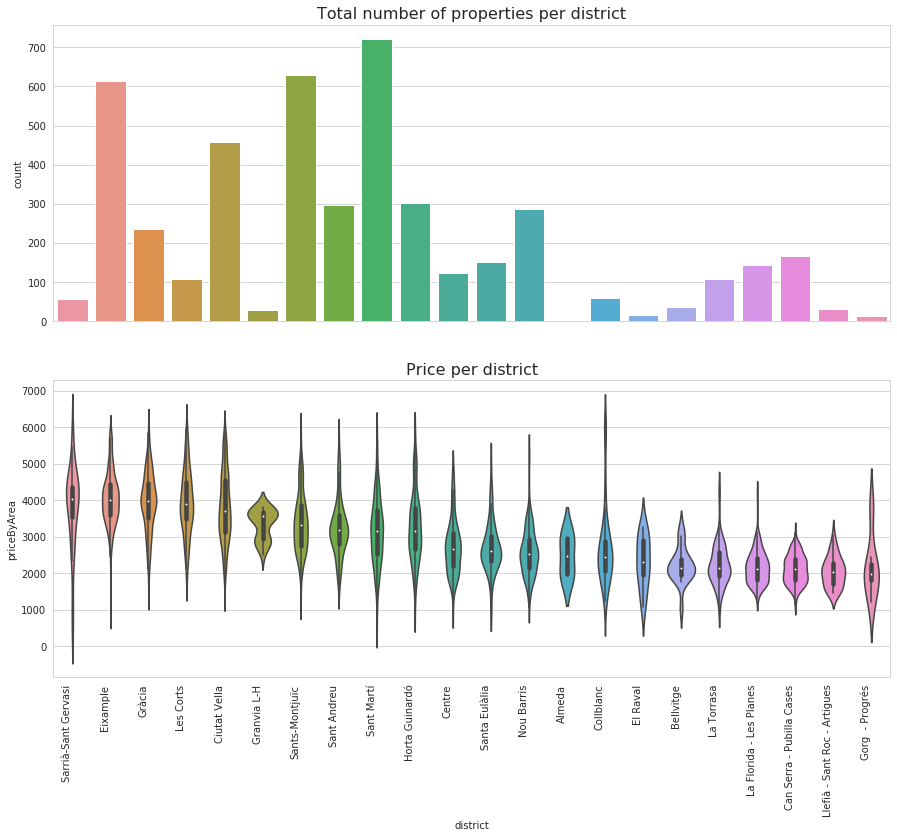

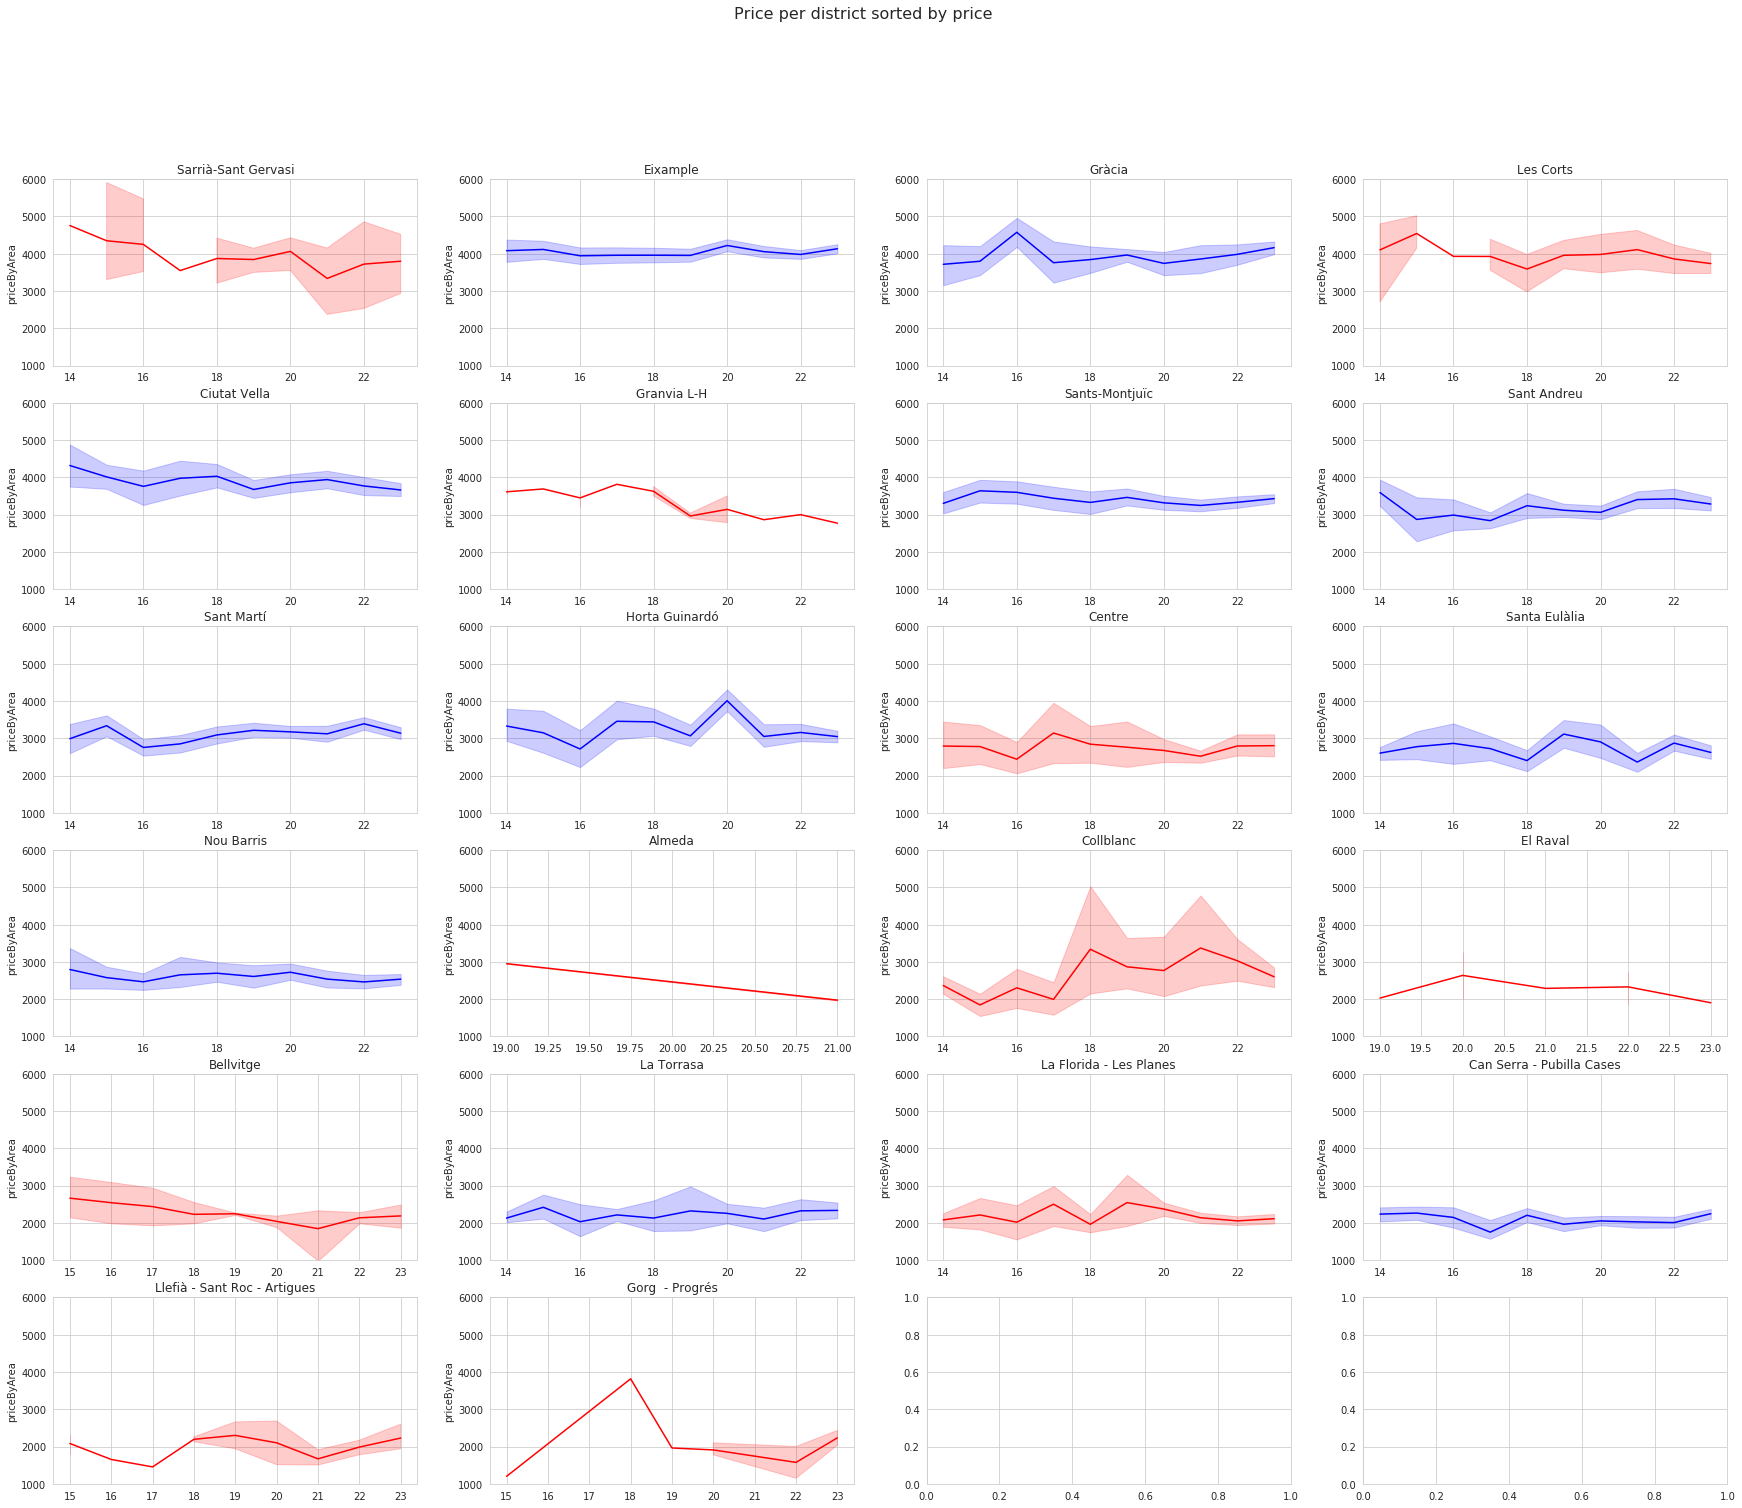

In [21]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)

# plot districts from expensive to chean
order = df.groupby('district')['priceByArea'].median().sort_values(ascending=False).index

sns.countplot(x='district', data=df, order=order, orient='v', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_xlabel(None)
ax[0].set_title(
    'Total number of properties per district', fontsize=16);

sns.violinplot(y='priceByArea', x='district', data=df, order=order, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right')
ax[1].set_title(
    'Price per district', fontsize=16);



# Price vs. time
figNum = df['district'].unique().size
figRow = np.ceil( figNum / 4 ).astype('int')
fig_size = (30, 4*figRow)

fig, ax = plt.subplots(figRow,4, figsize=fig_size)

for i in range(figNum):
    Index = order[i]
    aux = df.loc[df['district'] == Index]
    
    # if there are more than 4 samples per week, plot it blue
    if np.all(aux.Week.value_counts()>4):
        color = 'blue'
    else:
        color = 'red'
    
    sns.lineplot(x='Week', y='priceByArea', color = color, data=aux, ax=ax[np.unravel_index(i, (figRow,4))])
    ax[np.unravel_index(i, (figRow,4))].set_title(Index)
    ax[np.unravel_index(i, (figRow,4))].set_ylim(1000,6000)
    ax[np.unravel_index(i, (figRow,4))].set_xlabel(None)
fig.suptitle('Price per district sorted by price', fontsize=16);

### Analyze prices per neighbourhood
The first figure shows the count and price by area of neihborhoods sorted by the median district price.
The second figure shows the mean prices and confidence intervals of neighborhoods plotted per week. The subplots are also plotted by the median neighborhood price.

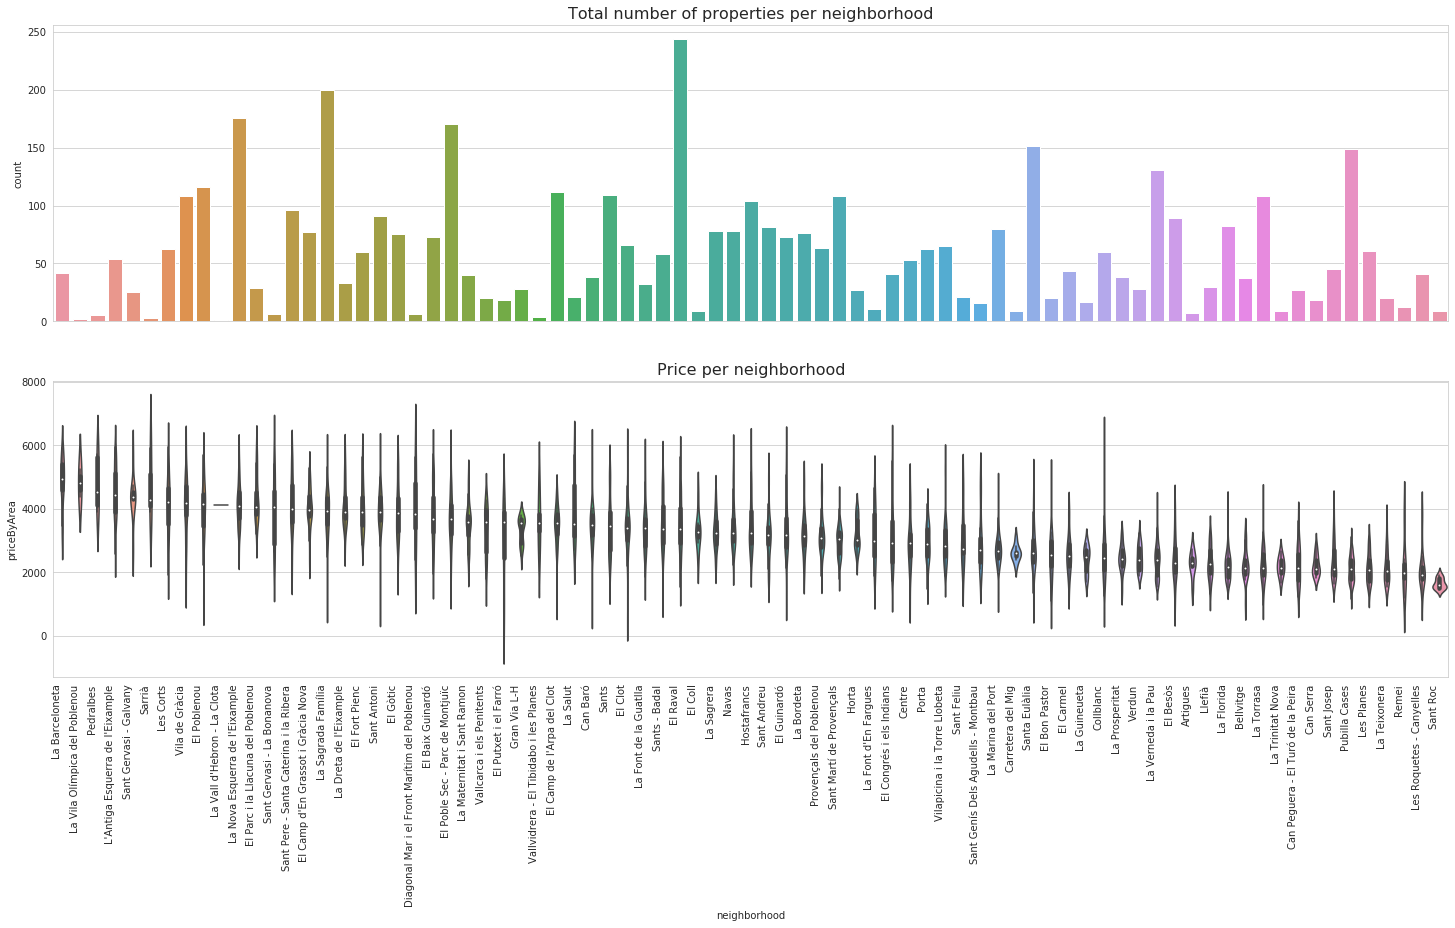

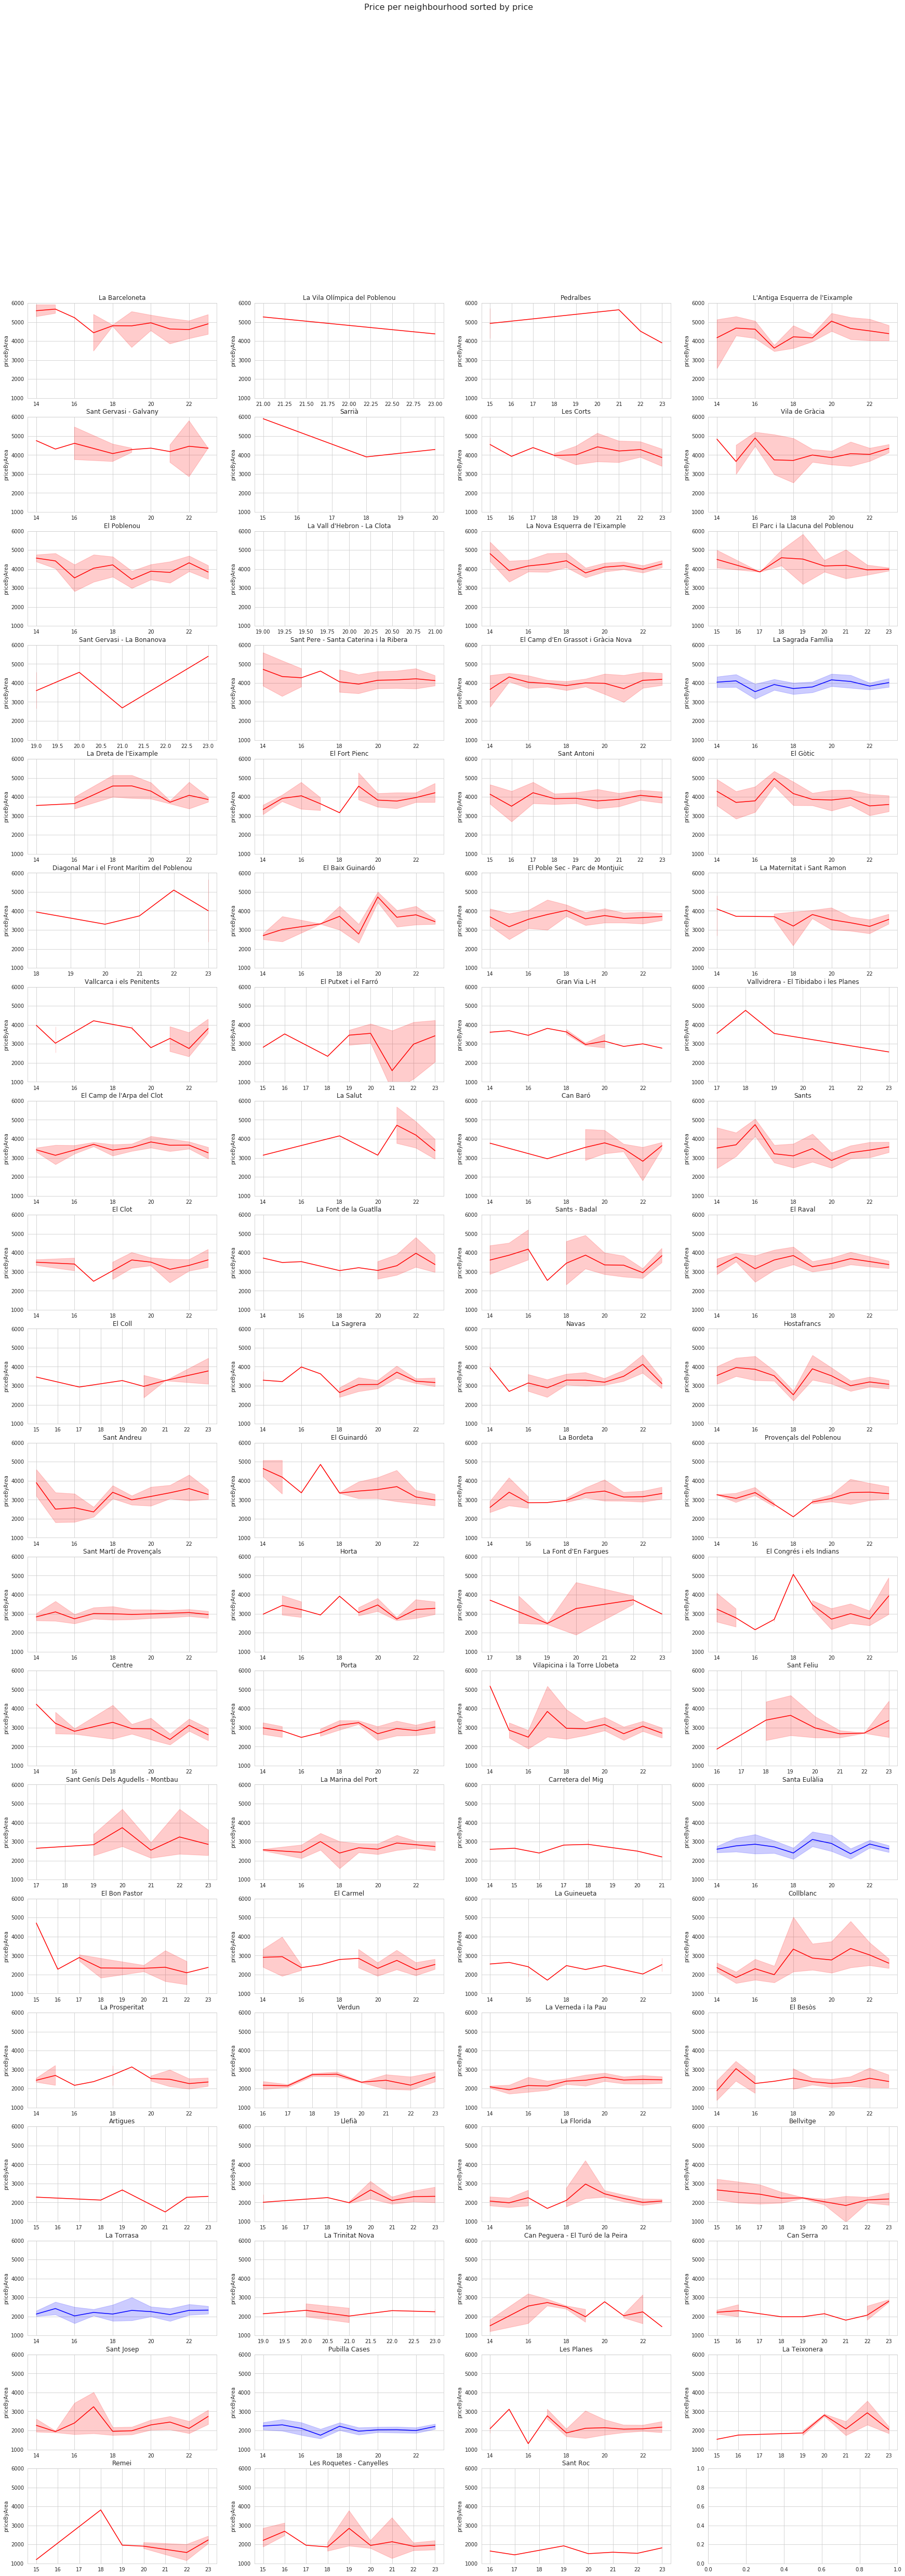

In [22]:
fig_size = (25, 12)
fig, ax = plt.subplots(2, figsize=fig_size)

# plot neighborhoods sorted by price
order = df.groupby('neighborhood')['priceByArea'].median().sort_values(ascending=False).index

# plot neighbourhoods sorted by number of adds
# order = df.neighborhood.value_counts().index

sns.countplot(x='neighborhood', data=df, order=order, orient='v', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_xlabel(None)
ax[0].set_title(
    'Total number of properties per neighborhood', fontsize=16);

sns.violinplot(y='priceByArea', x='neighborhood', data=df, order=order, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right')
ax[1].set_title(
    'Price per neighborhood', fontsize=16);



# Price vs. time
figNum = df['neighborhood'].unique().size
figRow = np.ceil( figNum / 4 ).astype('int')
fig_size = (30, 4*figRow)

fig, ax = plt.subplots(figRow,4, figsize=fig_size)

for i in range(figNum):
    Index = order[i]
    aux = df.loc[df['neighborhood'] == Index]
    
    # if there are more than 4 samples per week, plot it blue
    if np.all(aux.Week.value_counts()>4):
        color = 'blue'
    else:
        color = 'red'
    
    sns.lineplot(x='Week', y='priceByArea', color = color, data=aux, ax=ax[np.unravel_index(i, (figRow,4))])
    ax[np.unravel_index(i, (figRow,4))].set_title(Index)
    ax[np.unravel_index(i, (figRow,4))].set_ylim(1000,6000)
    ax[np.unravel_index(i, (figRow,4))].set_xlabel(None)
fig.suptitle('Price per neighbourhood sorted by price', fontsize=16);

# Analysis of apartment status

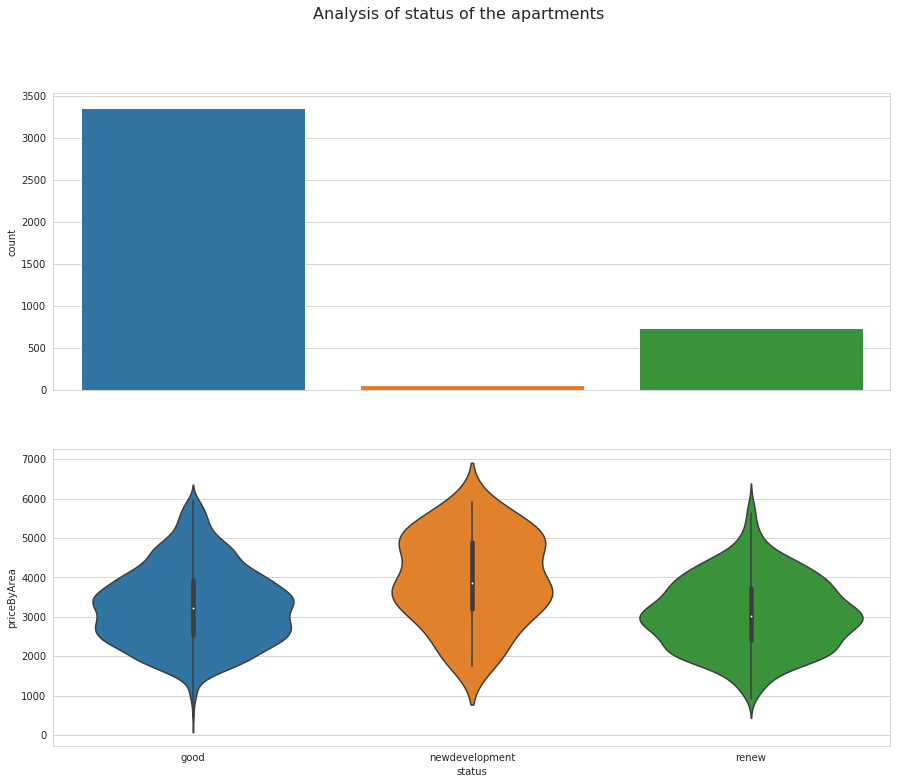

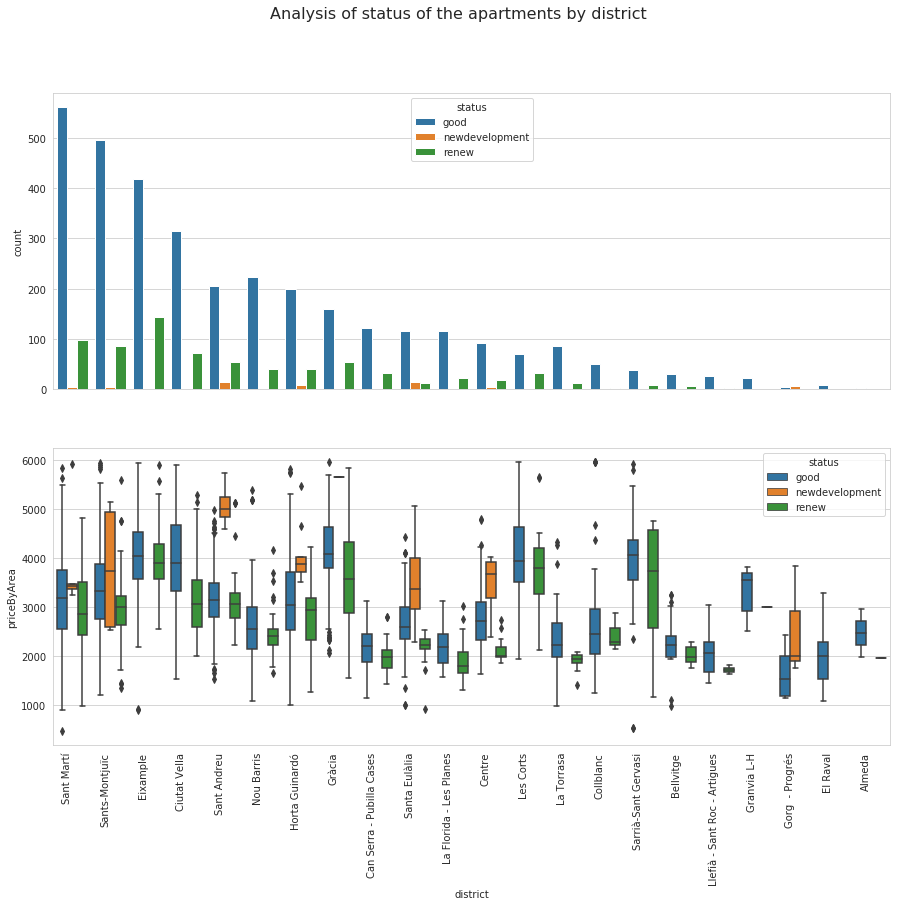

In [23]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='status', data=df, ax=ax[0]);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);
sns.violinplot(y='priceByArea', x= 'status', data=df, ax=ax[1])
fig.suptitle('Analysis of status of the apartments', fontsize=16);

fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='status', data=df, ax=ax[0],
             order=df.groupby('district')['status'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);
sns.boxplot(x='district', y='priceByArea', hue='status',data=df,ax=ax[1],
           order=df.groupby('district')['status'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Analysis of status of the apartments by district', fontsize=16);

## Analysis of elevator
Check if the elevator has an effect on the price

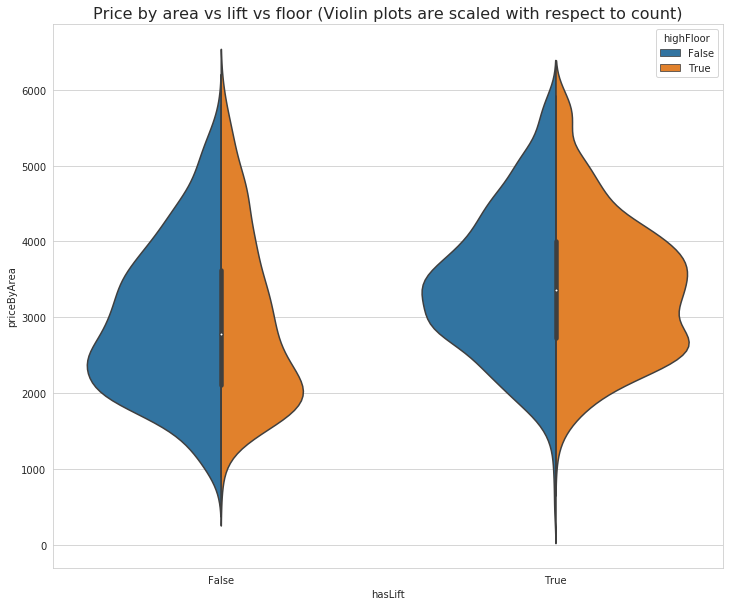

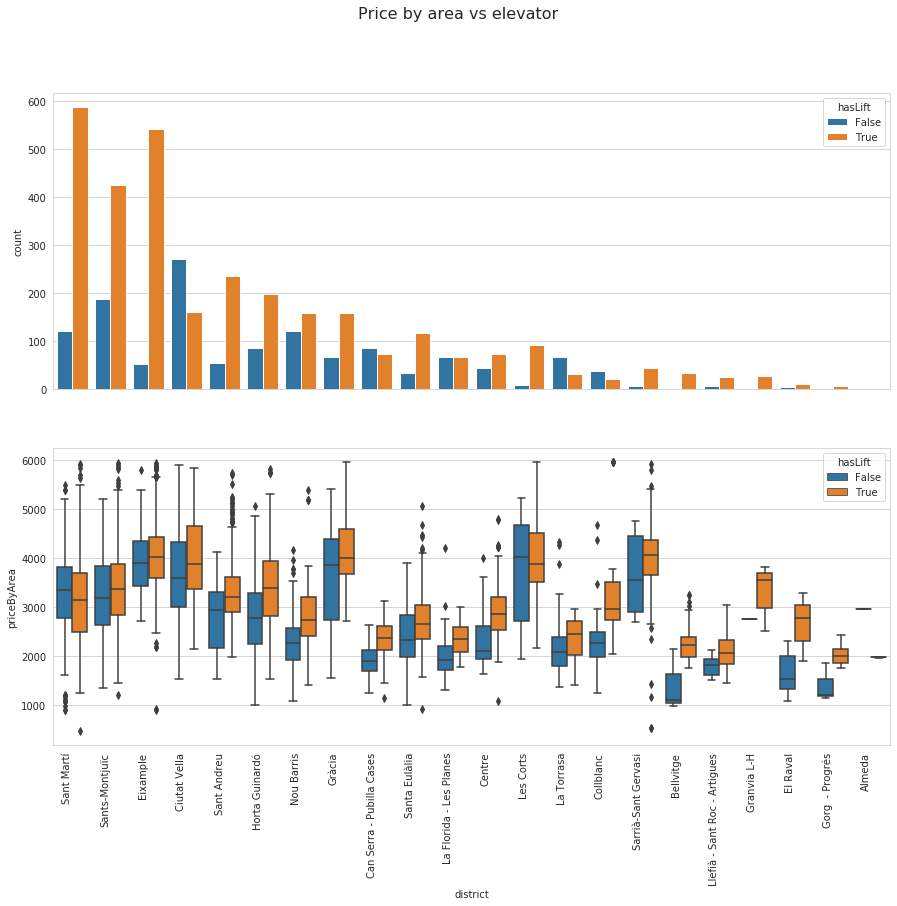

In [24]:
# Compare price by area depending on the floor and the lift
fig_size = (12, 10)
fig, ax = plt.subplots(1, figsize=fig_size)
aux=df
aux['highFloor']=False
aux.loc[aux['floorSort']>2, 'highFloor'] = True
sns.violinplot(x='hasLift', y='priceByArea', hue='highFloor', scale='count', split=True, data=aux,ax=ax);
ax.set_title('Price by area vs lift vs floor (Violin plots are scaled with respect to count)', fontsize=16);

fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='hasLift', data=df, ax=ax[0],
             order=df.groupby('district')['hasLift'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);

sns.boxplot(x='district', y='priceByArea', hue='hasLift', data=df,ax=ax[1],
           order=df.groupby('district')['hasLift'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Price by area vs elevator', fontsize=16);

## Exterior/interior
Check  the effect of interior/exterior property on the price

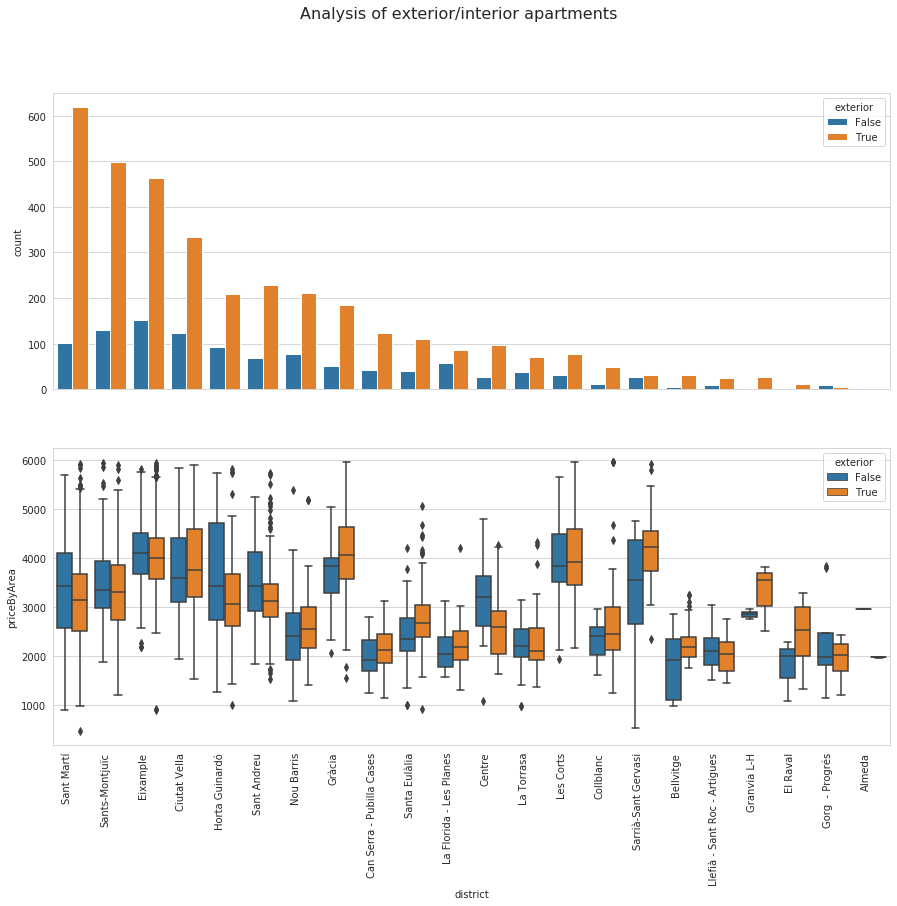

In [25]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='exterior', data=df, ax=ax[0],
             order=df.groupby('district')['exterior'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);

sns.boxplot(x='district', y='priceByArea', hue='exterior',data=df,ax=ax[1],
           order=df.groupby('district')['exterior'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Analysis of exterior/interior apartments', fontsize=16);

# Price Prediction
Using regression a price for each property is predicted. The properties with a significantly lower price than the predicted value are identified as a good investment oportunity.

### Organize and clean the data

In [26]:
# Print the names of the columns
print('Available features are:')
for i in df.columns:
    print(i, end=', ')

df_model = df[['propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
              'latitude', 'longitude', 'priceByArea', 'status', 'hasLift', 'Week', 'floorCategorical']]
df_model.isnull().sum()

Available features are:
propertyCode, floor, price, propertyType, size, exterior, rooms, bathrooms, district, neighborhood, latitude, longitude, priceByArea, status, hasLift, Week, duplicatesIndex, duplicates, duplicatesCount, dupPriceMin, dupPriceMax, dupPriceByAreaMin, dupPriceByAreaMax, dupWeekMin, dupWeekMax, dupPriceDifference, dupPriceDifference%, floorSort, floorCategorical, geometry, highFloor, 

propertyType          0
size                  0
exterior              0
rooms                 0
bathrooms             0
latitude              0
longitude             0
priceByArea           0
status              428
hasLift             170
Week                  0
floorCategorical    349
dtype: int64

In [27]:
# Prepare data for classification
def clean_modelling_data(df, dropNaN=True):
    data = df.copy()
    
    # drop NaNs
    numberOfNans = data.isnull().sum().sum()/data.shape[0]
    #assert numberOfNans<0.05, "Oh no! The number of NaNs is "+str(numberOfNans)+"%"
    print("The number of NaNs is "+str(numberOfNans)+"%")
    if dropNaN==True:
        print ("NaN's dropped.")
        data = data.dropna().reset_index(drop=True)
        
        # Warning! transforms Nan to True
        data['exterior'] = data['exterior'].astype('bool')
        data['exterior'] = data['exterior'].astype('uint8')
        data['hasLift'] = data['hasLift'].astype('bool')
        data['hasLift'] = data['hasLift'].astype('uint8')
        
        data = pd.get_dummies(data)
        
    else:
        # Warning! transforms Nan to True
        data['exterior'] = data['exterior'].astype('bool')
        data['exterior'] = data['exterior'].astype('uint8')
        data['hasLift'] = data['hasLift'].astype('bool')
        data['hasLift'] = data['hasLift'].astype('uint8')
        
        data = pd.get_dummies(data, dummy_na=True)
        
    return data

#df_model = clean_modelling_data(df_model)

### Linear Regression
#### Gradient Boosting Regressor
Improved the linear regression using ensemble learner

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [29]:
# create the regressor
# if featureImportane = True perform the feature importance analysis as well.
def regressor(x_train,y_train,x_test,y_test, featureImportance=False):
    params = {'n_estimators': 400,
          'max_depth': 12,
          'min_samples_split': 2,
          'learning_rate': 0.01,
          'loss': 'ls'}
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(x_train, y_train)

    mse_train = mean_squared_error(y_train, reg.predict(x_train))
    mse_test = mean_squared_error(y_test, reg.predict(x_test))
    R2_train = reg.score(x_train,y_train)
    R2_test = reg.score(x_test,y_test)
    print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse_test))
    print("\nThe R square (R2) on train set: {:.4f}".format(R2_train))
    print("The R square (R2) on test set: {:.4f}".format(R2_test))

    test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
    for i, y_pred in enumerate(reg.staged_predict(x_test)):
        test_score[i] = reg.loss_(y_test, y_pred)

    fig,ax= plt.subplots(1,figsize=(15, 10))

    plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
            label='Training Set Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test set deviance')

    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')
    plt.title('Deviance')

    fig,ax= plt.subplots(1,figsize=(15, 10))
    sns.scatterplot(x=y_test, y=reg.predict(x_test));
    ax.set_ylabel('Predicted price by area');
    ax.set_xlabel('True price by area');
    ax.set_title('Price by area prediction', fontsize=16);
    
    if featureImportance:
        feature_importance = reg.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        fig = plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, np.array(train1.columns)[sorted_idx])
        plt.title('Feature Importance (MDI)')

        result = permutation_importance(reg, x_test, y_test, n_repeats=10,
                                        random_state=42, n_jobs=2)
        sorted_idx = result.importances_mean.argsort()
        plt.subplot(1, 2, 2)
        plt.boxplot(result.importances[sorted_idx].T,
                    vert=False, labels=np.array(train1.columns)[sorted_idx])
        plt.title("Permutation Importance (test set)")
        fig.tight_layout()
    
    return reg


The number of NaNs is 0.2064530194026597%
NaN's dropped.
Available features are:
size, exterior, rooms, bathrooms, latitude, longitude, priceByArea, hasLift, Week, propertyType_chalet, propertyType_countryHouse, propertyType_duplex, propertyType_flat, propertyType_penthouse, propertyType_studio, status_good, status_newdevelopment, status_renew, floorCategorical_High, floorCategorical_Low, floorCategorical_Mid, floorCategorical_Penthouse, floorCategorical_bj, floorCategorical_en, floorCategorical_ss, 

The mean squared error (MSE) on train set: 13330.2312
The mean squared error (MSE) on test set: 295909.9836

The R square (R2) on train set: 0.9860
The R square (R2) on test set: 0.6743


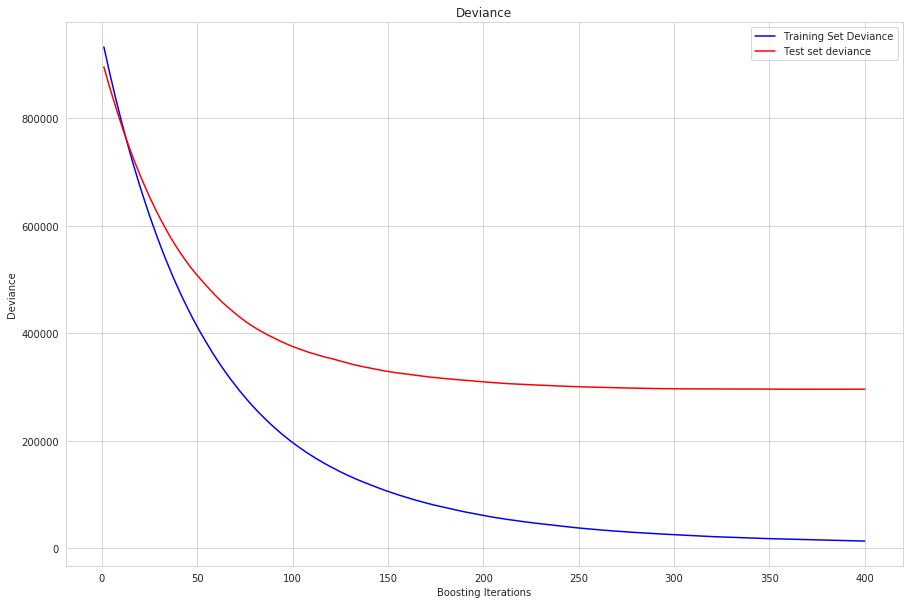

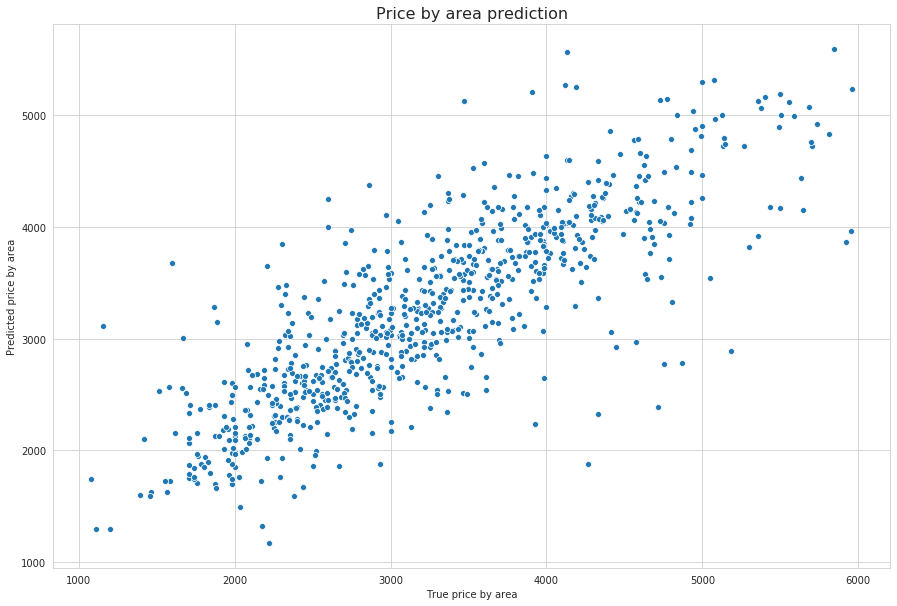

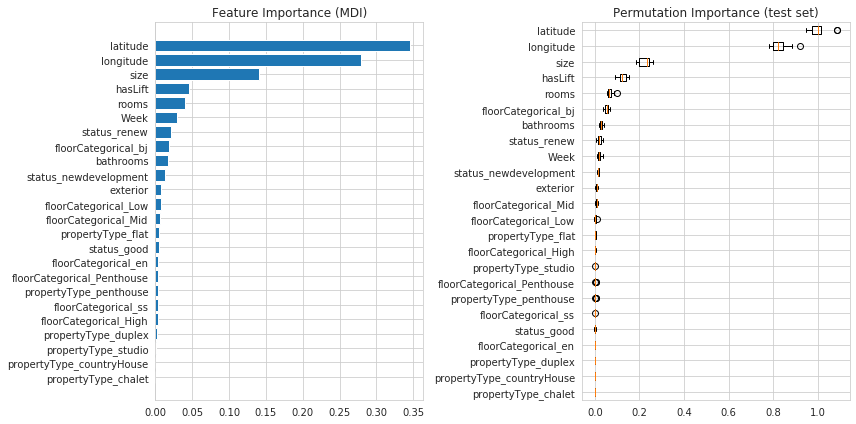

In [30]:
# rain and test regressor with dropped NaNs
df_model = df[['propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
              'latitude', 'longitude', 'priceByArea', 'status', 'hasLift', 'Week', 'floorCategorical']]
df_model = clean_modelling_data(df_model, dropNaN=True)

# Print the names of the columns
print('Available features are:')
for i in df_model.columns:
    print(i, end=', ')
print('\n')

labels = df_model['priceByArea']
train1 = df_model.drop(['priceByArea'],axis=1)
x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.2,random_state =2)

reg = regressor(x_train,y_train, x_test,y_test, featureImportance=True)

In [ ]:
# Train and test regressor with filled NaNs
df_model = df[['propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
              'latitude', 'longitude', 'priceByArea', 'status', 'hasLift', 'Week', 'floorCategorical']]
df_model = clean_modelling_data(df_model, dropNaN=False)

# Fill missing values 
df_model.propertyType_flat.loc[df_model['propertyType_nan']==1] = 1
df_model.status_good.loc[df_model['status_nan']==1] = 1
df_model.floorCategorical_Low.loc[df_model['floorCategorical_nan']==1] = 1

df_model.drop(['propertyType_nan'],axis=1, inplace=True)
df_model.drop(['status_nan'],axis=1, inplace=True)
df_model.drop(['floorCategorical_nan'],axis=1, inplace=True)

# Print the names of the columns
print('Available features are:')
for i in df_model.columns:
    print(i, end=', ')
print('\n')

labels = df_model['priceByArea']
train1 = df_model.drop(['priceByArea'],axis=1)
x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.25,random_state =2)

reg = regressor(x_train,y_train, x_test,y_test, featureImportance=True)

The number of NaNs is 0.2064530194026597%
Available features are:
size, exterior, rooms, bathrooms, latitude, longitude, priceByArea, hasLift, Week, propertyType_chalet, propertyType_countryHouse, propertyType_duplex, propertyType_flat, propertyType_penthouse, propertyType_studio, status_good, status_newdevelopment, status_renew, floorCategorical_High, floorCategorical_Low, floorCategorical_Mid, floorCategorical_Penthouse, floorCategorical_bj, floorCategorical_en, floorCategorical_ss, 

The mean squared error (MSE) on train set: 12907.0764
The mean squared error (MSE) on test set: 370721.9248

The R square (R2) on train set: 0.9869
The R square (R2) on test set: 0.6213


### Identify the best offers in terms of Price by Area

#### Train the model on all samples

In [ ]:
# Recreate feature set, drop propertyType
df_model = df[['propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
              'latitude', 'longitude', 'priceByArea', 'status', 'hasLift', 'Week', 'floorCategorical']]

# Select wether to drop NaNs or impute the missing values
#dropNaNs = 'DropAll' # Drop all NaNs
#dropNaNs = 'DropNone' # Don't drop any NaNs
dropNaNs = 'ExceptLastWeek' # Don't drop NaNs only in last week


if dropNaNs=='DropAll':
    print("Drop NaNs")
    df_model = clean_modelling_data(df_model, dropNaN=True)
    y_train = df_model['priceByArea']
    y_test = y_train
    x_train = df_model.drop(['priceByArea'],axis=1)
    x_test = x_train
    
    

elif dropNaNs=='DropNone':
    print("Don't drop NaNs")
    df_model = clean_modelling_data(df_model, dropNaN=False)
    # Fill missing values 
    df_model.propertyType_flat.loc[df_model['propertyType_nan']==1] = 1
    df_model.status_good.loc[df_model['status_nan']==1] = 1
    df_model.floorCategorical_Low.loc[df_model['floorCategorical_nan']==1] = 1

    df_model.drop(['propertyType_nan'],axis=1, inplace=True)
    df_model.drop(['status_nan'],axis=1, inplace=True)
    df_model.drop(['floorCategorical_nan'],axis=1, inplace=True)
    
    y_train = df_model['priceByArea']
    y_test = y_train
    x_train = df_model.drop(['priceByArea'],axis=1)
    x_test = x_train
    
    
    
elif dropNaNs=='ExceptLastWeek':
    # Drop NaNs if not last week
    df_model1 = clean_modelling_data(df_model.loc[df_model['Week']!=df_model.Week.max()], dropNaN=True)
    # Don't drop if last week
    df_model2 = clean_modelling_data(df_model.loc[df_model['Week']==df_model.Week.max()], dropNaN=False)
    # Fill missing values 
    df_model2.propertyType_flat.loc[df_model2['propertyType_nan']==1] = 1
    df_model2.status_good.loc[df_model2['status_nan']==1] = 1
    df_model2.floorCategorical_Low.loc[df_model2['floorCategorical_nan']==1] = 1

    df_model2.drop(['propertyType_nan'],axis=1, inplace=True)
    df_model2.drop(['status_nan'],axis=1, inplace=True)
    df_model2.drop(['floorCategorical_nan'],axis=1, inplace=True)
    
    # Concatenate the two models
    df_model = pd.concat([df_model1, df_model2])
    
    y_train = df_model['priceByArea']
    y_test = y_train
    x_train = df_model.drop(['priceByArea'],axis=1)
    x_test = x_train
    

# Print the names of the columns
print('Using features:')
for i in x_train.columns:
    print(i, end=', ')
print('\n')


y_train = df_model['priceByArea']
y_test = y_train
x_train = df_model.drop(['priceByArea'],axis=1)
x_test = x_train

reg = regressor(x_train,y_train, x_test,y_test, featureImportance=False)


#### Create new columns in df with predicted price, and price difference and savings with respect to the predicticted price

In [ ]:
df_model['predictedPrice'] = reg.predict(df_model.drop(['priceByArea'],axis=1))
# Price difference = PredictedPrice- priceByArea ==> the higher numbers are better investment
df_model['priceDifference'] = df_model['predictedPrice']-df_model['priceByArea']

try:
    df = df.drop(['predictedPrice', 'priceDifference'], axis=1)
except:
    print ("Columns are being created")
    
df=df.join(df_model[['predictedPrice', 'priceDifference']])
    
df['savings'] = df['size']*df['priceDifference']

Show and analyze further only the properties cheaper more than 'threshold' than predicted price (e.g. 10 000 euros).

In [ ]:
# show only the properties cheaper by threashold from predicted price 
savingThreashold = 5000
df_investment=df.loc[df['savings'] > savingThreashold]

# show the investment options published last week
df_investment.sort_values(by='savings',ascending=False).head(50)

#### Plot the identified properties on the map

In [ ]:
gdf = gpd.GeoDataFrame(
    df_investment, geometry=gpd.points_from_xy(df_investment.longitude, df_investment.latitude))
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

figsize = (15, 15)
fig, ax = plt.subplots(1, figsize=figsize)
gdf.plot(column='savings', cmap='hot', legend=True, alpha=0.9, ax=ax);
ctx.add_basemap(ax)
ax.set_title("Savings - all property types", fontsize=16);

figsize = (15, 15)
fig, ax = plt.subplots(1, figsize=figsize)
gdf.loc[gdf['propertyType'] == 'penthouse'].plot(
    column='savings', cmap='hot', legend=True, alpha=0.9, ax=ax);
ctx.add_basemap(ax)
ax.set_title("Savings - Penthouses", fontsize=16);

In [ ]:
fig,ax= plt.subplots(2,figsize=(15, 10))
sns.scatterplot(x='size', y='savings', hue= 'propertyType', data=df_investment,ax=ax[0]);
#sns.scatterplot(x='size', y='priceByArea', hue= 'savings', data=df,ax=ax[1]);
sns.scatterplot(x='size', y='priceByArea', size= 'savings', hue='propertyType', data=df_investment,ax=ax[1]);
ax[0].set_title('Last weeks offers with respect to size');

## Show only the last week properties


In [ ]:
df_investment=df.loc[df['Week']==df.Week.max()]

# show only the properties cheaper by threashold from predicted price 
savingThreashold = 5000

gdf = gpd.GeoDataFrame(
    df_investment, geometry=gpd.points_from_xy(df_investment.longitude, df_investment.latitude))
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

if gdf.empty==False:
    figsize = (15, 15)
    fig, ax = plt.subplots(1, figsize=figsize)
    gdf.plot(column='savings', cmap='hot', legend=True, alpha=0.9, ax=ax);
    ctx.add_basemap(ax)
    ax.set_title("Last week savings - all property types", fontsize=16);

if gdf.loc[gdf['propertyType'] == 'penthouse'].empty==False:
    figsize = (15, 15)
    fig, ax = plt.subplots(1, figsize=figsize)
    gdf.loc[gdf['propertyType'] == 'penthouse'].plot(
        column='savings', cmap='hot', legend=True, alpha=0.9, ax=ax);
    ctx.add_basemap(ax)
    ax.set_title("Last week savings - Penthouses", fontsize=16);

fig,ax= plt.subplots(2,figsize=(15, 10))
sns.scatterplot(x='size', y='savings', hue= 'propertyType', data=df_investment,ax=ax[0]);
ax[0].set_title('Last weeks offers with respect to size')
#sns.scatterplot(x='size', y='priceByArea', hue= 'savings', data=df,ax=ax[1]);
sns.scatterplot(x='size', y='priceByArea', size= 'savings', hue='propertyType', data=df_investment.loc[(df_investment['savings'] > savingThreashold)],ax=ax[1]);
ax[1].set_title('Last weeks offers with high savings with respect to size');

#### Get the identifier of the selected property

In [ ]:
# E.g.:
df_investment.loc[(df_investment['size'] > 60) & (df_investment['size'] < 100) & (
    df_investment['propertyType'] == 'penthouse')].sort_values(by='savings', ascending=False)
